In [1]:
#Basic tools
import pandas as pd
import numpy as np
from sklearn.preprocessing import Normalizer, StandardScaler, PowerTransformer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import itertools
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, make_scorer, recall_score, f1_score

# modeling
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm

import tensorflow as tf
from tensorflow.keras import regularizers



#Utilities
from utils import *

Using TensorFlow backend.


### Importing Customer Data and Payment Data

In [2]:
df_cust = pd.read_csv("customer_data_ratio20.csv")
df_cust.head()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141


In [3]:
df_paym = pd.read_csv("payment_data_ratio20.csv")
df_paym.head()

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date
0,58987402,0,0,0,0,1,10,16500.0,04/12/2016,0.0,NaN,NaN
1,58995151,0,0,0,0,1,5,NaN,04/12/2016,588720.0,491100.0,NaN
2,58997200,0,0,0,0,2,5,NaN,04/12/2016,840000.0,700500.0,22/04/2016
3,54988608,0,0,0,0,3,10,37400.0,03/12/2016,8425.2,7520.0,25/04/2016
4,54987763,0,0,0,0,2,10,NaN,03/12/2016,15147.6,NaN,26/04/2016


Merging Customer Data and Payment Data with 'id' as key

In [4]:
#Merging df_cust and df_paym
df = pd.merge(df_cust, df_paym, how='inner', on='id')
df.head()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,...,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,...,0,0,0,9,10,60500.0,31/01/2015,6657.6,18934.0,19/09/2015
1,1,54982665,5,1245.5,3,77000.0,2,15,5,109,...,0,0,0,18,10,NaN,28/04/2009,153792.0,149387.0,10/08/2015
2,1,54982665,5,1245.5,3,77000.0,2,15,5,109,...,0,0,0,1,5,NaN,30/03/2009,0.0,150500.0,NaN
3,1,54982665,5,1245.5,3,77000.0,2,15,5,109,...,2,26,11906,6,10,NaN,17/05/2007,0.0,46371.0,12/07/2013
4,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,...,0,0,0,4,6,NaN,02/06/2016,15120.0,21500.0,19/04/2016


In [5]:
#Size of tables
print(df_paym.shape)
print(df_cust.shape)
print(df.shape)

(8250, 12)
(1125, 13)
(8250, 24)


In [6]:
#Number of entriers having label values 0 or 1 
df['label'].value_counts()

0    6863
1    1387
Name: label, dtype: int64

Handling null values

In [7]:
#Percentage of null values for each column
null_0 = pd.DataFrame(df[df['label']==0].isnull().sum()/(df['label'].value_counts()[0])*100, columns=["Low Risk"])
null_1 = pd.DataFrame(df[df['label']==1].isnull().sum()/(df['label'].value_counts()[1])*100, columns=["High Risk"])
pd.concat([null_0, null_1], axis =1)

,Low Risk,High Risk
label,0.000000,0.000000
id,0.000000,0.000000
fea_1,0.000000,0.000000
fea_2,11.671281,16.366258
fea_3,0.000000,0.000000
fea_4,0.000000,0.000000
fea_5,0.000000,0.000000
fea_6,0.000000,0.000000
fea_7,0.000000,0.000000
fea_8,0.000000,0.000000


In [8]:
#Filling the missing values in fea_2 column with median of the demography
df['fea_2'].fillna(df['fea_2'].median(), inplace=True)  

### Feature building for payment data to make prepare data for credit risk prediction

In [9]:
#Missing values of highest_balance filled with the corresponding new_balance
df['highest_balance'] = df.apply(lambda x: x['new_balance'] if np.isnan(x['highest_balance']) else x['highest_balance'], axis=1)

Since 'prod_limit' have many null values. I assume that null value entries has 0 'prod_limit'

In [10]:
df['prod_limit'].fillna(0, inplace=True)

In [11]:
#Converting object datatype to datetime for update_date and report_date
df['update_date'] = pd.to_datetime(df['update_date'])
df['report_date'] = pd.to_datetime(df['report_date'])
df.dtypes

label                       int64
id                          int64
fea_1                       int64
fea_2                     float64
fea_3                       int64
fea_4                     float64
fea_5                       int64
fea_6                       int64
fea_7                       int64
fea_8                       int64
fea_9                       int64
fea_10                      int64
fea_11                    float64
OVD_t1                      int64
OVD_t2                      int64
OVD_t3                      int64
OVD_sum                     int64
pay_normal                  int64
prod_code                   int64
prod_limit                float64
update_date        datetime64[ns]
new_balance               float64
highest_balance           float64
report_date        datetime64[ns]
dtype: object

In [12]:
#Filling in missing values for update_date with median of the update date in the demography
m = pd.Timestamp(np.median(df['update_date'].to_numpy().astype(np.int64))) 
df['update_date'].fillna(m, inplace=True)

In [13]:
#Missing values of report_date filled with the corresponding update_date
df['report_date'] = df.apply(lambda x: x['update_date'] if x['report_date']is pd.NaT else x['report_date'], axis=1)

Converting dates to day of week and day of year to capture weekly and yearly seasonality

In [14]:
#Day of week
df['update_day'] = [i.dayofweek for i in df['update_date']]
df['report_day'] = [i.dayofweek for i in df['report_date']]
#Day of year
df['update_day_year'] = [i.dayofyear for i in df['update_date']]
df['report_day_year'] = [i.dayofyear for i in df['report_date']]
df = df.drop(['update_date','report_date'], axis = 1)

### Data Exploration

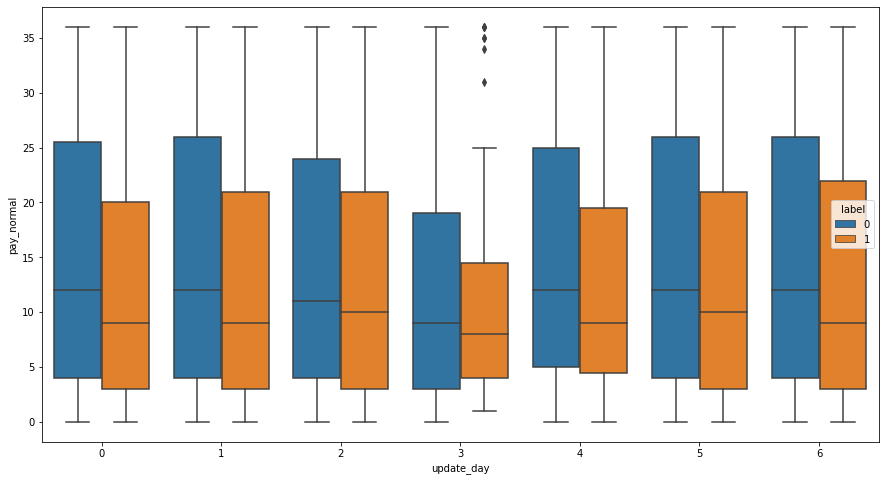

In [15]:
# Weekly updation by customers with their corresponding normal pay numbers.
## Thursday (3) is frequented by cusomers with least normal pay numbers.
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(ax=ax, x ='update_day', y='pay_normal', data=df, hue='label')

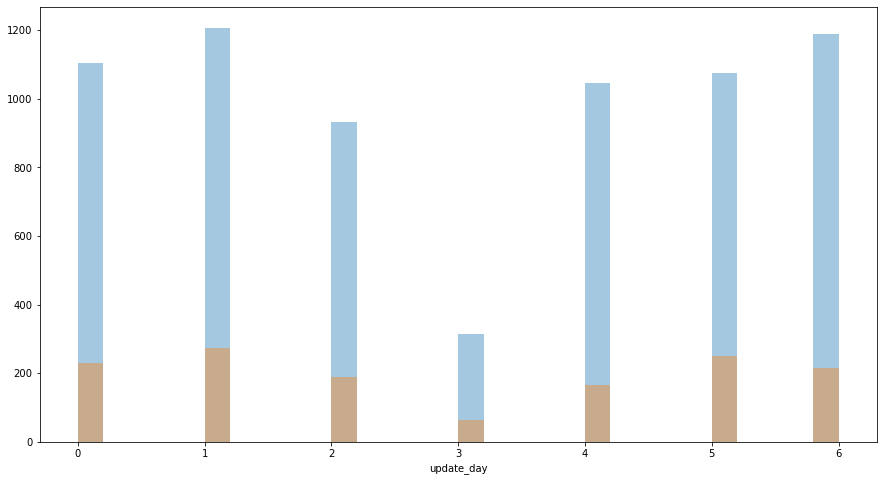

In [16]:
# Weekly numbers of updation by low risk and high risk customers 
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(df[df['label']==0]['update_day'], ax=ax, bins=30, kde = False)
sns.distplot(df[df['label']==1]['update_day'], ax=ax, bins=30, kde = False)

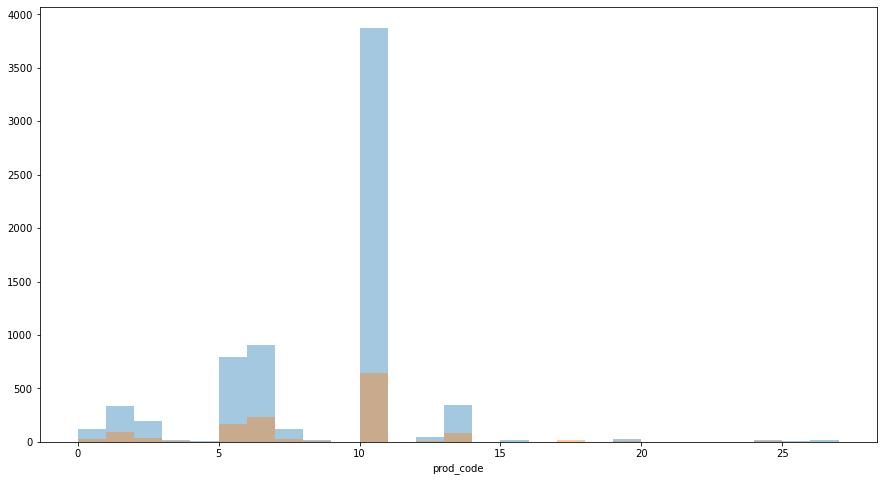

In [17]:
# Number of customers with low risk and high risk subscribing a product
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(df[df['label']==0]['prod_code'], ax=ax, bins=27, kde = False)
sns.distplot(df[df['label']==1]['prod_code'], ax=ax, bins=26, kde = False)

In [18]:
# Total numbers for each product code
df['prod_code'].value_counts()

10    4523
6     1144
5      962
1      427
13     425
2      239
0      147
7      147
12      56
19      35
8       24
24      24
17      22
15      22
3       21
26      14
25       5
4        4
9        3
27       3
22       3
Name: prod_code, dtype: int64

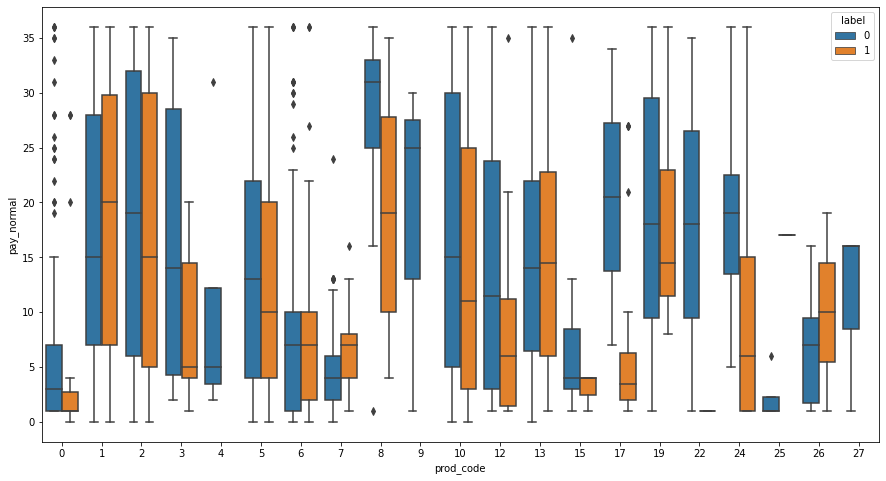

In [19]:
# Products with distribution of customers with number of normal pay 
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(ax=ax, x ='prod_code', y='pay_normal', data=df, hue='label')

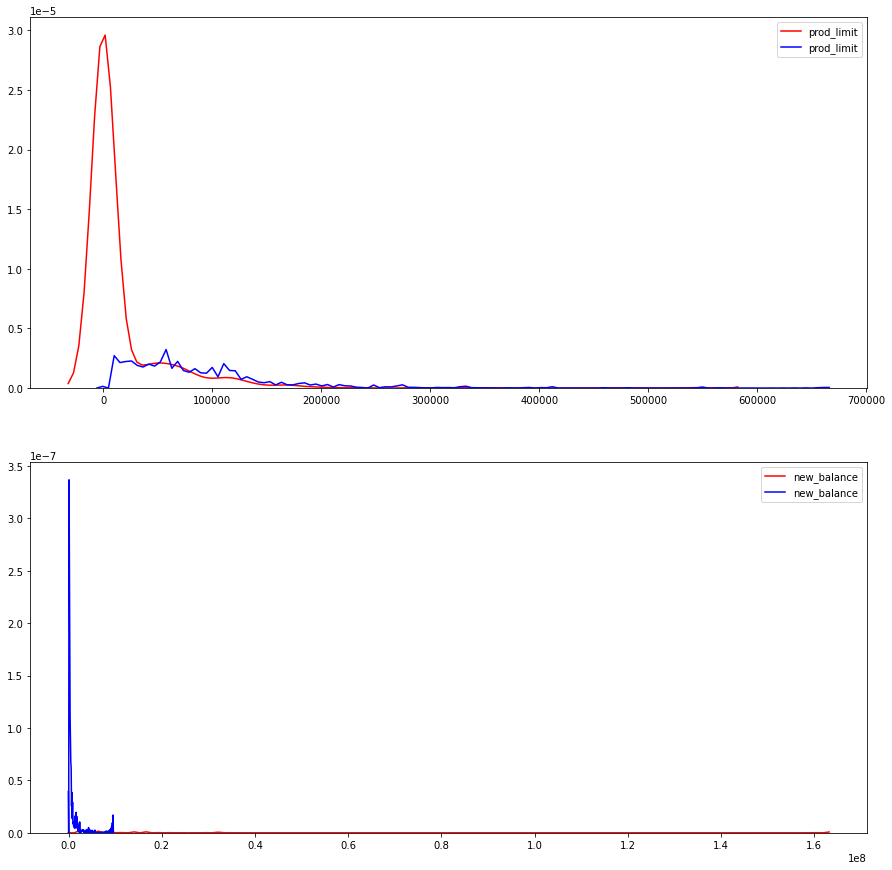

In [20]:
# Density of cutomers for product limit value
## Red is high risk and blue is low risk
### 0 product limit has highest high risk customers
fig, ax = plt.subplots(2, 1, figsize=(15,15))
sns.kdeplot(df['prod_limit'].loc[df['label'] == 1], ax=ax[0],  color='r')
sns.kdeplot(df['prod_limit'].loc[df['label'] == 0], ax=ax[0],  color='b')

# Density of cutomers for new balance value
## Red is high risk and blue is low risk
### Low 
sns.kdeplot(df['new_balance'].loc[df['label'] == 1], ax=ax[1], color='r')
sns.kdeplot(df['new_balance'].loc[df['label'] == 0], ax=ax[1], color='b')

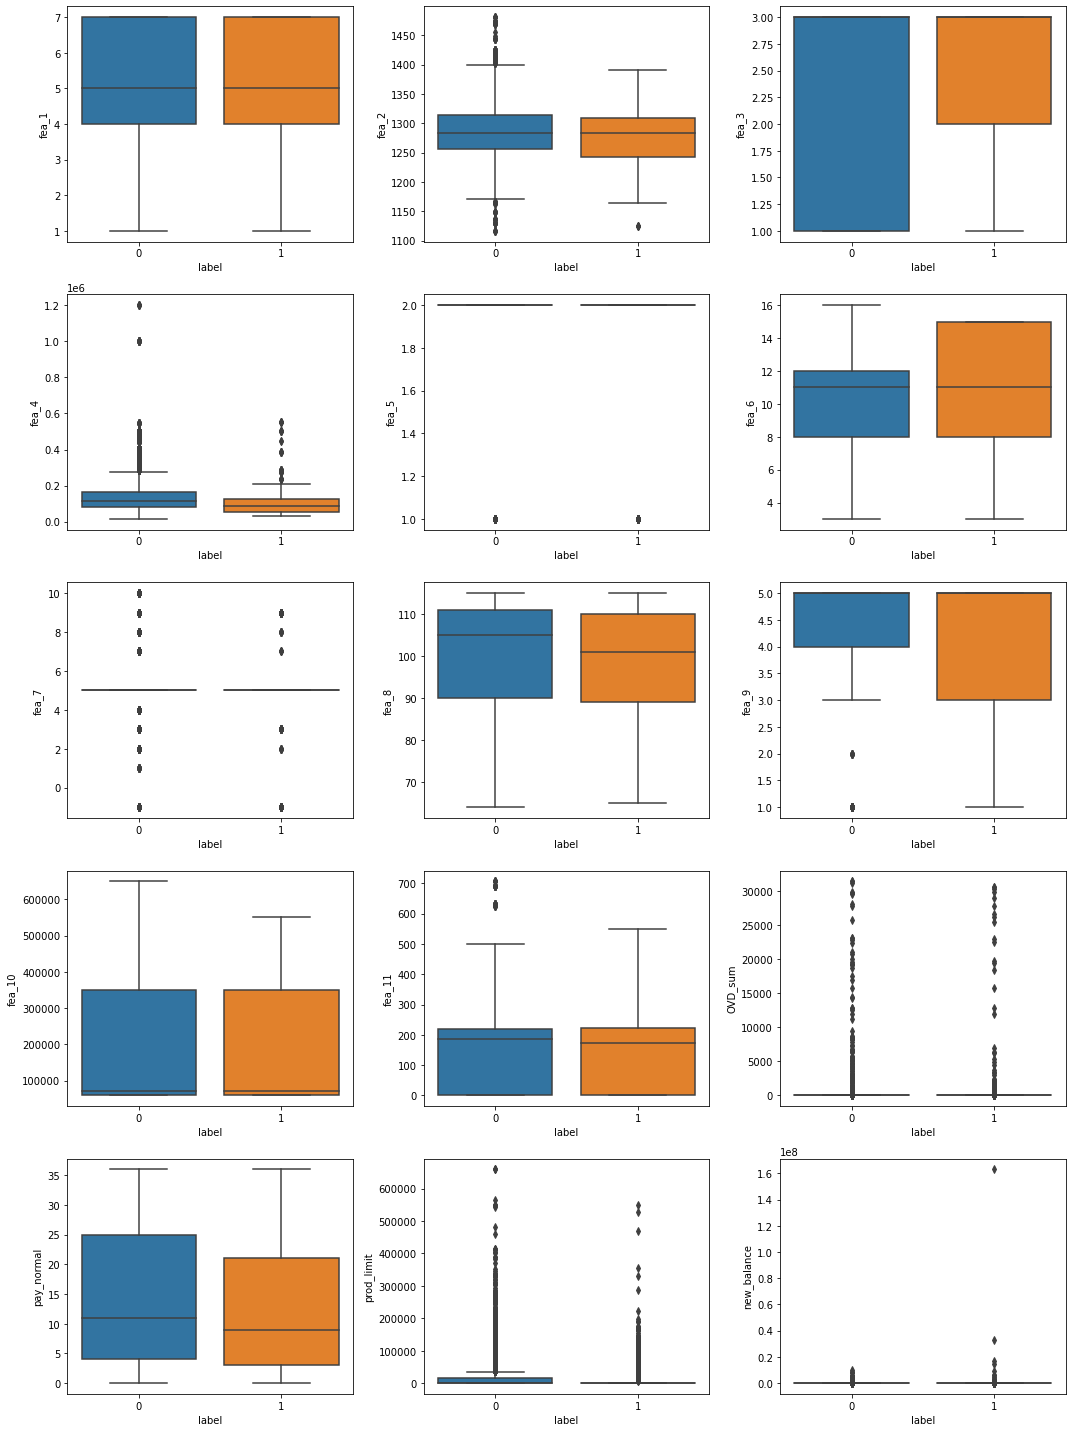

In [21]:
# Boxplot for demographic features
fig, ax = plt.subplots(5,3,figsize=(15, 20))
sns.boxplot(ax=ax[0,0], x ='label', y='fea_1', data=df)
sns.boxplot(ax=ax[0,1], x ='label', y='fea_2', data=df)
sns.boxplot(ax=ax[0,2], x ='label', y='fea_3', data=df)
sns.boxplot(ax=ax[1,0], x ='label', y='fea_4', data=df)
sns.boxplot(ax=ax[1,1], x ='label', y='fea_5', data=df)
sns.boxplot(ax=ax[1,2], x ='label', y='fea_6', data=df)
sns.boxplot(ax=ax[2,0], x ='label', y='fea_7', data=df)
sns.boxplot(ax=ax[2,1], x ='label', y='fea_8', data=df)
sns.boxplot(ax=ax[2,2], x ='label', y='fea_9', data=df)
sns.boxplot(ax=ax[3,0], x ='label', y='fea_10', data=df)
sns.boxplot(ax=ax[3,1], x ='label', y='fea_11', data=df)
sns.boxplot(ax=ax[3,2], x ='label', y='OVD_sum', data=df)
sns.boxplot(ax=ax[4,0], x ='label', y='pay_normal', data=df)
sns.boxplot(ax=ax[4,1], x ='label', y='prod_limit', data=df)
sns.boxplot(ax=ax[4,2], x ='label', y='new_balance', data=df)
plt.tight_layout()

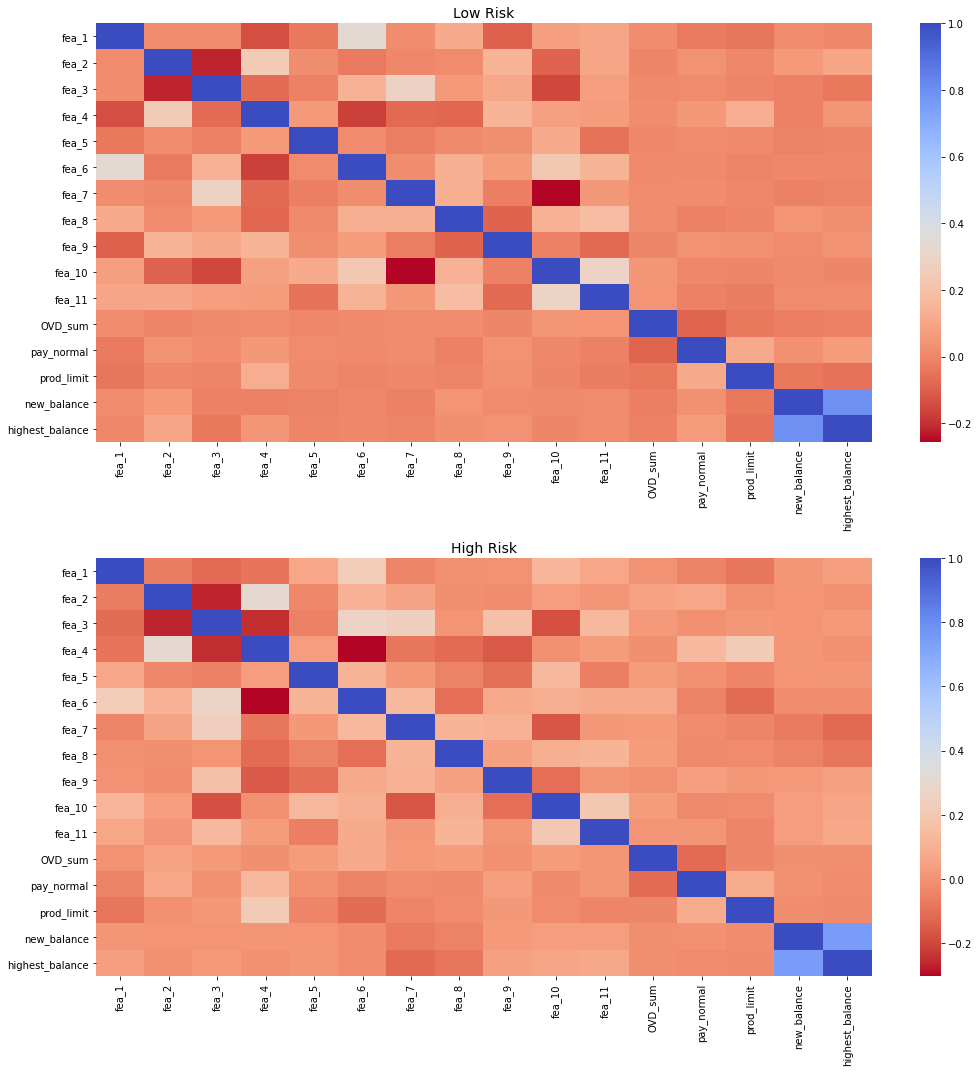

In [22]:
# Correlation heatmap of all parameters
## low correlation among all parameters except new balance and highest balance
fig, (ax1, ax2)  = plt.subplots(2, 1, figsize=(15, 15))
sns.heatmap(df[df['label']==0][['fea_1', 'fea_2', 'fea_3', 'fea_4', 'fea_5', 'fea_6', 'fea_7', 'fea_8', 'fea_9', 'fea_10', 'fea_11', 'OVD_sum', 'pay_normal', 'prod_limit', 'new_balance', 'highest_balance']].corr(), cmap='coolwarm_r', ax=ax1)
ax1.set_title("Low Risk", fontsize=14)
sns.heatmap(df[df['label']==1][['fea_1', 'fea_2', 'fea_3', 'fea_4', 'fea_5', 'fea_6', 'fea_7', 'fea_8', 'fea_9', 'fea_10', 'fea_11', 'OVD_sum', 'pay_normal', 'prod_limit', 'new_balance', 'highest_balance']].corr(), cmap='coolwarm_r', ax=ax2)
ax2.set_title("High Risk", fontsize=14)
plt.tight_layout()

### Data Preperation

In [23]:
#Normalization
scaler = StandardScaler()
scaler.fit(df[['fea_1', 'fea_2', 'fea_3', 'fea_4', 'fea_5', 'fea_6', 'fea_7', 'fea_8', 'fea_9', 'fea_10', 'fea_11', 'OVD_t1', 'OVD_t2',
               'OVD_t3', 'OVD_sum', 'pay_normal', 'prod_code', 'prod_limit', 'new_balance', 'highest_balance', 'update_day', 'report_day', 'update_day_year', 'report_day_year']])
X_scaled = scaler.transform(df[['fea_1', 'fea_2', 'fea_3', 'fea_4', 'fea_5', 'fea_6', 'fea_7', 'fea_8', 'fea_9', 'fea_10', 'fea_11', 
                                'OVD_t1', 'OVD_t2', 'OVD_t3', 'OVD_sum', 'pay_normal', 'prod_code', 'prod_limit', 'new_balance', 'highest_balance', 'update_day', 'report_day', 'update_day_year', 'report_day_year']])
X_scaled.shape

(8250, 24)

In [24]:
#Dataframe for scaled data
X_scaled = pd.DataFrame(X_scaled, columns = ['fea_1', 'fea_2', 'fea_3', 'fea_4', 'fea_5', 'fea_6', 'fea_7', 'fea_8', 'fea_9', 
                                             'fea_10', 'fea_11', 'OVD_t1', 'OVD_t2', 'OVD_t3', 'OVD_sum', 'pay_normal', 
                                             'prod_code', 'prod_limit', 'new_balance', 'highest_balance', 
                                             'update_day', 'report_day', 'update_day_year', 'report_day_year'])
X_scaled[['label']] = df[['label']]
X_scaled.head()

,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,...,pay_normal,prod_code,prod_limit,new_balance,highest_balance,update_day,report_day,update_day_year,report_day_year,label
0,-0.376487,-0.827401,0.766728,-0.570237,0.25074,1.479361,0.039222,0.715645,0.860908,-0.223178,...,-0.458534,0.500447,0.719478,-0.052314,-0.069169,0.929477,0.906024,-1.425998,0.753939,1
1,-0.376487,-0.827401,0.766728,-0.570237,0.25074,1.479361,0.039222,0.715645,0.860908,-0.223178,...,0.288174,0.500447,-0.416149,0.025635,-0.021629,-0.929590,-0.037275,-0.601830,0.920643,1
2,-0.376487,-0.827401,0.766728,-0.570237,0.25074,1.479361,0.039222,0.715645,0.860908,-0.223178,...,-1.122275,-0.914845,-0.416149,-0.055841,-0.021224,-1.394357,-1.452223,-0.876553,-0.763946,1
3,-0.376487,-0.827401,0.766728,-0.570237,0.25074,1.479361,0.039222,0.715645,0.860908,-0.223178,...,-0.707437,0.500447,-0.416149,-0.055841,-0.059170,-0.000056,0.906024,-0.421839,1.447077,1
4,-1.096806,-0.180086,-1.487148,-0.237366,0.25074,-1.118574,-1.939854,-0.002098,-1.420650,0.917153,...,-0.873372,-0.631786,-0.416149,-0.047830,-0.068233,0.929477,-0.980573,-1.369158,-0.579694,0


In [25]:
# define X and y variables
X = X_scaled[['fea_1', 'fea_2', 'fea_3', 'fea_4', 'fea_5', 'fea_6', 'fea_7', 'fea_8', 'fea_9', 'fea_10', 'fea_11', 
              'OVD_t1', 'OVD_t2', 'OVD_t3', 'OVD_sum', 'pay_normal', 'prod_code', 'prod_limit', 'new_balance', 
              'highest_balance', 'update_day', 'report_day', 'update_day_year', 'report_day_year']]
y = X_scaled['label']

In [26]:
# Splitting of Training and Testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=5)

In [27]:
lists = ['fea_1', 'fea_2', 'fea_3', 'fea_4', 'fea_5', 'fea_6', 'fea_7', 'fea_8', 
             'fea_9', 'fea_10', 'fea_11', 'OVD_t1', 'OVD_t2', 'OVD_t3', 'OVD_sum', 
             'pay_normal', 'prod_code', 'prod_limit', 'new_balance', 'highest_balance', 
             'update_day', 'report_day', 'update_day_year', 'report_day_year']
X_true = X_scaled[X_scaled['label']==0][lists]
X_train_true, X_test_true = train_test_split(X, test_size=0.33, random_state=5)

# Model selection

### Isolation forest

In [28]:
#Optimised results after gridsearch
rs=np.random.RandomState(0)
clf = IsolationForest(max_samples=.15, n_estimators= 7, random_state=rs, contamination=0.9)

y_pred = model_predict_USL(X_train_true, clf, X_test)

In [29]:
# Results
class_report_IF=report_USL(y_pred, y_test)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.79      0.09      0.16      2268
           1       0.16      0.87      0.27       455

    accuracy                           0.22      2723
   macro avg       0.47      0.48      0.22      2723
weighted avg       0.68      0.22      0.18      2723

CONFUSION MATRIX
[[ 209 2059]
 [  57  398]]


In [29]:
#GridSearch for parameters
scoring = {'AUC': 'roc_auc', 'Recall': make_scorer(recall_score, pos_label=-1)}

gs = GridSearchCV(IsolationForest(max_samples=0.25, random_state=11, contamination = 0.15, n_jobs=-1),
                  param_grid={'n_estimators': range(1, 10, 1), 
                              'max_samples': np.arange(0.1, 0.3, 0.05), 
                              'contamination': np.arange(0.2, 1.1, 0.1)
                             },
                  scoring=scoring, refit='Recall')

y_pred, gs = model_predict_SL(gs, X_train, y_train, X_test)

C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\ensemble\_iforest.py", line 290, in fit
    100. * self.contamination)
  File "<__array_function__ internals>", line 6, in percentile
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\numpy\lib\function_base.py", line 3731, in percentile
    raise ValueError("Percentiles must be in the range [0, 100]")
ValueError: Percentiles must be in the range [0, 100]

  FitFailedWarning)
C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_v

C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\ensemble\_iforest.py", line 290, in fit
    100. * self.contamination)
  File "<__array_function__ internals>", line 6, in percentile
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\numpy\lib\function_base.py", line 3731, in percentile
    raise ValueError("Percentiles must be in the range [0, 100]")
ValueError: Percentiles must be in the range [0, 100]

  FitFailedWarning)
C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_v

C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\ensemble\_iforest.py", line 290, in fit
    100. * self.contamination)
  File "<__array_function__ internals>", line 6, in percentile
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\numpy\lib\function_base.py", line 3731, in percentile
    raise ValueError("Percentiles must be in the range [0, 100]")
ValueError: Percentiles must be in the range [0, 100]

  FitFailedWarning)
C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_v

C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\ensemble\_iforest.py", line 290, in fit
    100. * self.contamination)
  File "<__array_function__ internals>", line 6, in percentile
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\numpy\lib\function_base.py", line 3731, in percentile
    raise ValueError("Percentiles must be in the range [0, 100]")
ValueError: Percentiles must be in the range [0, 100]

  FitFailedWarning)
C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_v

C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\ensemble\_iforest.py", line 290, in fit
    100. * self.contamination)
  File "<__array_function__ internals>", line 6, in percentile
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\numpy\lib\function_base.py", line 3731, in percentile
    raise ValueError("Percentiles must be in the range [0, 100]")
ValueError: Percentiles must be in the range [0, 100]

  FitFailedWarning)
C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_v

C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\ensemble\_iforest.py", line 290, in fit
    100. * self.contamination)
  File "<__array_function__ internals>", line 6, in percentile
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\numpy\lib\function_base.py", line 3731, in percentile
    raise ValueError("Percentiles must be in the range [0, 100]")
ValueError: Percentiles must be in the range [0, 100]

  FitFailedWarning)
C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_v

C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\ensemble\_iforest.py", line 290, in fit
    100. * self.contamination)
  File "<__array_function__ internals>", line 6, in percentile
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\numpy\lib\function_base.py", line 3731, in percentile
    raise ValueError("Percentiles must be in the range [0, 100]")
ValueError: Percentiles must be in the range [0, 100]

  FitFailedWarning)
C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_v

C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\ensemble\_iforest.py", line 290, in fit
    100. * self.contamination)
  File "<__array_function__ internals>", line 6, in percentile
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\numpy\lib\function_base.py", line 3731, in percentile
    raise ValueError("Percentiles must be in the range [0, 100]")
ValueError: Percentiles must be in the range [0, 100]

  FitFailedWarning)
C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_v

C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\ensemble\_iforest.py", line 290, in fit
    100. * self.contamination)
  File "<__array_function__ internals>", line 6, in percentile
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\numpy\lib\function_base.py", line 3731, in percentile
    raise ValueError("Percentiles must be in the range [0, 100]")
ValueError: Percentiles must be in the range [0, 100]

  FitFailedWarning)
C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_v

C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\ensemble\_iforest.py", line 290, in fit
    100. * self.contamination)
  File "<__array_function__ internals>", line 6, in percentile
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\numpy\lib\function_base.py", line 3731, in percentile
    raise ValueError("Percentiles must be in the range [0, 100]")
ValueError: Percentiles must be in the range [0, 100]

  FitFailedWarning)
C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_v

C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\ensemble\_iforest.py", line 290, in fit
    100. * self.contamination)
  File "<__array_function__ internals>", line 6, in percentile
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\numpy\lib\function_base.py", line 3731, in percentile
    raise ValueError("Percentiles must be in the range [0, 100]")
ValueError: Percentiles must be in the range [0, 100]

  FitFailedWarning)
C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_v

C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\ensemble\_iforest.py", line 290, in fit
    100. * self.contamination)
  File "<__array_function__ internals>", line 6, in percentile
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\numpy\lib\function_base.py", line 3731, in percentile
    raise ValueError("Percentiles must be in the range [0, 100]")
ValueError: Percentiles must be in the range [0, 100]

  FitFailedWarning)
C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_v

C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\ensemble\_iforest.py", line 290, in fit
    100. * self.contamination)
  File "<__array_function__ internals>", line 6, in percentile
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\numpy\lib\function_base.py", line 3731, in percentile
    raise ValueError("Percentiles must be in the range [0, 100]")
ValueError: Percentiles must be in the range [0, 100]

  FitFailedWarning)
C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_v

C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\ensemble\_iforest.py", line 290, in fit
    100. * self.contamination)
  File "<__array_function__ internals>", line 6, in percentile
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\numpy\lib\function_base.py", line 3731, in percentile
    raise ValueError("Percentiles must be in the range [0, 100]")
ValueError: Percentiles must be in the range [0, 100]

  FitFailedWarning)
C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_v

C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\ensemble\_iforest.py", line 290, in fit
    100. * self.contamination)
  File "<__array_function__ internals>", line 6, in percentile
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\numpy\lib\function_base.py", line 3731, in percentile
    raise ValueError("Percentiles must be in the range [0, 100]")
ValueError: Percentiles must be in the range [0, 100]

  FitFailedWarning)
C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_v

C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\ensemble\_iforest.py", line 290, in fit
    100. * self.contamination)
  File "<__array_function__ internals>", line 6, in percentile
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\numpy\lib\function_base.py", line 3731, in percentile
    raise ValueError("Percentiles must be in the range [0, 100]")
ValueError: Percentiles must be in the range [0, 100]

  FitFailedWarning)
C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_v

C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\ensemble\_iforest.py", line 290, in fit
    100. * self.contamination)
  File "<__array_function__ internals>", line 6, in percentile
  File "C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\numpy\lib\function_base.py", line 3731, in percentile
    raise ValueError("Percentiles must be in the range [0, 100]")
ValueError: Percentiles must be in the range [0, 100]

  FitFailedWarning)
C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\sklearn\model_selection\_v

In [30]:
class_report=report_SL(y_pred, y_test)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.81      0.09      0.16      2266
           1       0.17      0.89      0.28       457

    accuracy                           0.23      2723
   macro avg       0.49      0.49      0.22      2723
weighted avg       0.70      0.23      0.18      2723

CONFUSION MATRIX
[[ 207 2059]
 [  49  408]]


In [31]:
results = gs.cv_results_
gs.best_params_

{'contamination': 0.9000000000000001,
 'max_samples': 0.15000000000000002,
 'n_estimators': 7}

C:\Users\shala\Documents\AI Lab - Technical Interview_Feb2021\AI Lab - Technical Interview\Anomaly Detection\utils.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


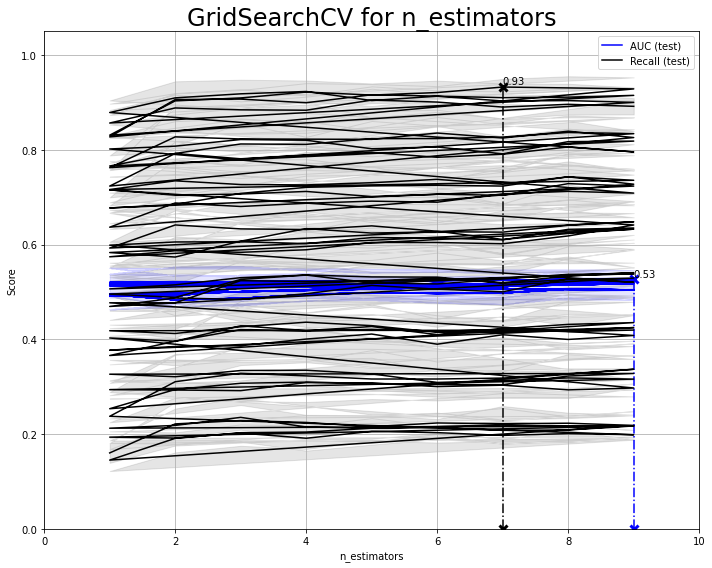

C:\Users\shala\Documents\AI Lab - Technical Interview_Feb2021\AI Lab - Technical Interview\Anomaly Detection\utils.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


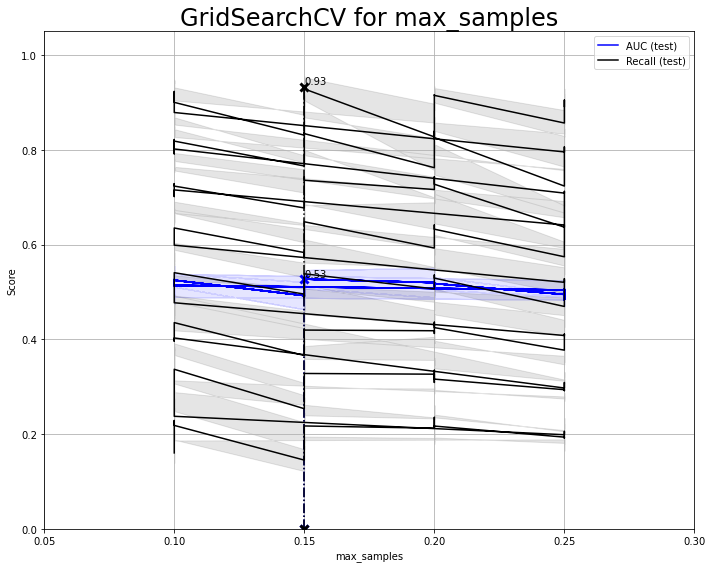

C:\Users\shala\Documents\AI Lab - Technical Interview_Feb2021\AI Lab - Technical Interview\Anomaly Detection\utils.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


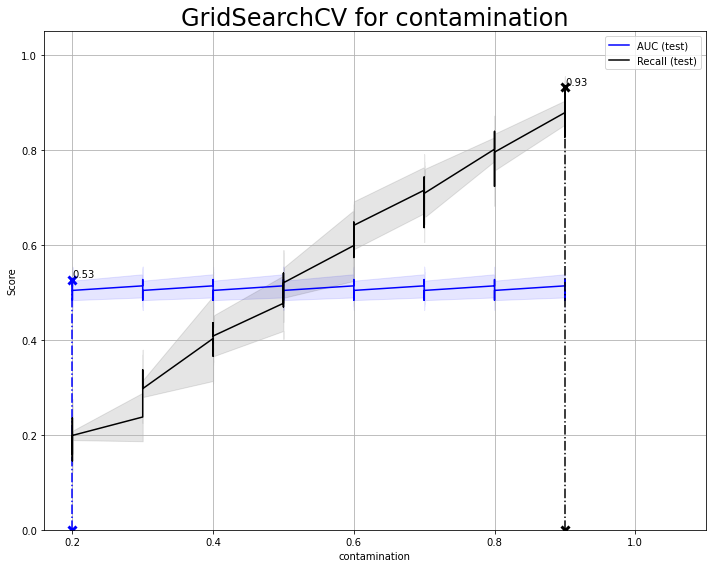

In [32]:
#Optimzation Process Graphs
plot_gridsearch_cv(results, "n_estimators", scoring, 0, 10, 0, 1.05)
plot_gridsearch_cv(results, "max_samples", scoring, 0.05, 0.3, 0, 1.05)
plot_gridsearch_cv(results, "contamination", scoring, 0.16, 1.1, 0, 1.05)

### Local Outlier Factor

In [30]:
#Optimised results after gridsearch
clf = LocalOutlierFactor(n_neighbors=5, novelty=True, contamination=0.5)

y_pred=model_predict_USL(X_train_true, clf, X_test)

In [31]:
# Results
class_report_LOF=report_USL(y_pred, y_test)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.84      0.45      0.59      2268
           1       0.17      0.56      0.26       455

    accuracy                           0.47      2723
   macro avg       0.50      0.51      0.43      2723
weighted avg       0.73      0.47      0.53      2723

CONFUSION MATRIX
[[1029 1239]
 [ 199  256]]


In [35]:
#GridSearch for parameters
scoring = {'AUC': 'roc_auc', 'Recall': make_scorer(recall_score, pos_label=-1)}

gs = GridSearchCV(LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1),
                  param_grid={'n_neighbors': range(1, 10, 1), 
                              'contamination': np.arange(0.05, 0.5, 0.05)
                             },
                  scoring=scoring, refit='Recall')

y_pred, gs = model_predict_SL(gs, X_train, y_train, X_test)

In [36]:
results = gs.cv_results_
gs.best_params_

{'contamination': 0.45, 'n_neighbors': 5}

In [37]:
class_report=report_SL(y_pred, y_test)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.84      0.49      0.62      2266
           1       0.18      0.55      0.27       457

    accuracy                           0.50      2723
   macro avg       0.51      0.52      0.45      2723
weighted avg       0.73      0.50      0.56      2723

CONFUSION MATRIX
[[1121 1145]
 [ 206  251]]


C:\Users\shala\Documents\AI Lab - Technical Interview_Feb2021\AI Lab - Technical Interview\Anomaly Detection\utils.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


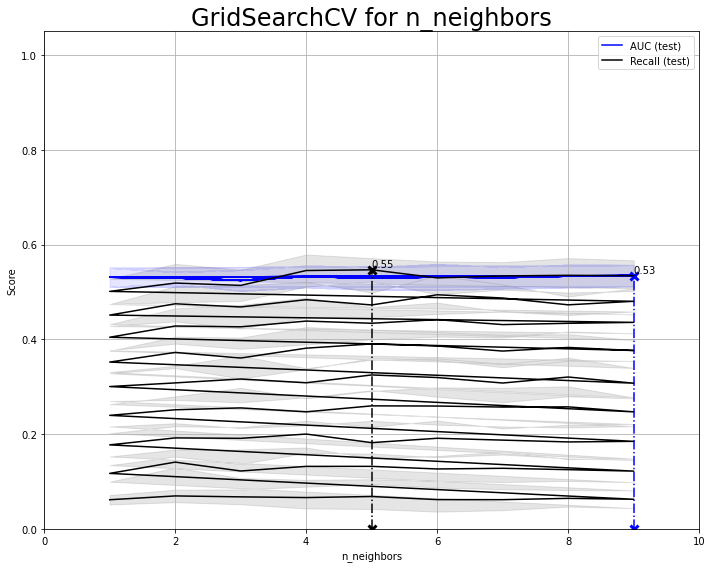

C:\Users\shala\Documents\AI Lab - Technical Interview_Feb2021\AI Lab - Technical Interview\Anomaly Detection\utils.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


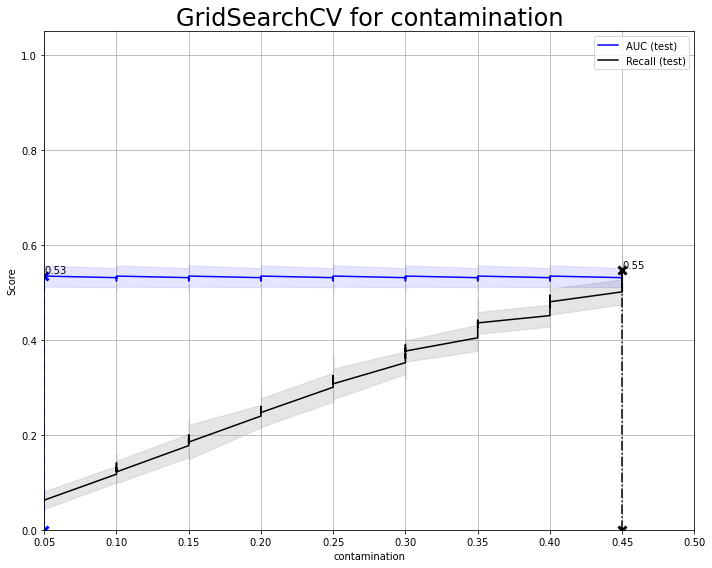

In [38]:
#Optimization process graphs
plot_gridsearch_cv(results, "n_neighbors", scoring, 0, 10, 0, 1.05)
plot_gridsearch_cv(results, "contamination", scoring, 0.05, 0.5, 0, 1.05)

### One-Class Support Vector Machines

In [32]:
#Optimised results after gridsearch
clf=svm.OneClassSVM(nu=.2, kernel='rbf', gamma=1, degree = 2)

lists = ['fea_1', 'fea_2', 'fea_3', 'fea_4', 'fea_5', 'fea_6', 'fea_7', 'fea_8', 'fea_9', 'fea_10', 'fea_11', 
         'OVD_t1', 'OVD_t2', 'OVD_t3', 'OVD_sum', 'pay_normal', 'prod_code', 'prod_limit', 'new_balance',
         'highest_balance', 'update_day', 'report_day', 'update_day_year', 'report_day_year']

y_pred=model_predict_USL(X_train_true, clf, X_test)

In [33]:
# Results
class_report_OSVM=report_USL(y_pred, y_test)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.77      0.01      0.03      2268
           1       0.17      0.98      0.28       455

    accuracy                           0.17      2723
   macro avg       0.47      0.50      0.16      2723
weighted avg       0.67      0.17      0.07      2723

CONFUSION MATRIX
[[  30 2238]
 [   9  446]]


In [29]:
#GridSearch for parameters
scoring = {'AUC': 'roc_auc', 'F1': make_scorer(f1_score, pos_label=-1)}
gs=GridSearchCV(svm.OneClassSVM(nu=.5,kernel='rbf',gamma=0.001), param_grid={"nu": [ 0.2, 0.3, 0.4], "gamma": [0.1, 0.5, 1.0, 1.5, 2.5], 'degree': [1,2,3,4,5]},
                scoring=scoring, refit='F1')

y_pred, gs = model_predict_SL(gs, X_train, y_train, X_test)

In [30]:
class_report=report_SL(y_pred, y_test)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.85      0.01      0.02      2266
           1       0.17      0.99      0.29       457

    accuracy                           0.17      2723
   macro avg       0.51      0.50      0.15      2723
weighted avg       0.73      0.17      0.06      2723

CONFUSION MATRIX
[[  22 2244]
 [   4  453]]


In [31]:
results = gs.cv_results_
gs.best_params_

{'degree': 1, 'gamma': 1.5, 'nu': 0.3}

C:\Users\shala\Documents\AI Lab - Technical Interview_Feb2021\AI Lab - Technical Interview\Anomaly Detection\utils.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


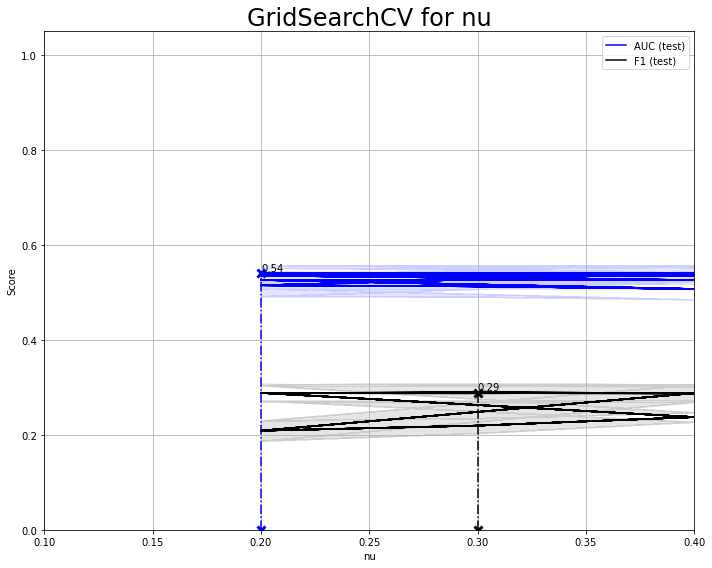

C:\Users\shala\Documents\AI Lab - Technical Interview_Feb2021\AI Lab - Technical Interview\Anomaly Detection\utils.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()
C:\Users\shala\Documents\AI Lab - Technical Interview_Feb2021\AI Lab - Technical Interview\Anomaly Detection\utils.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


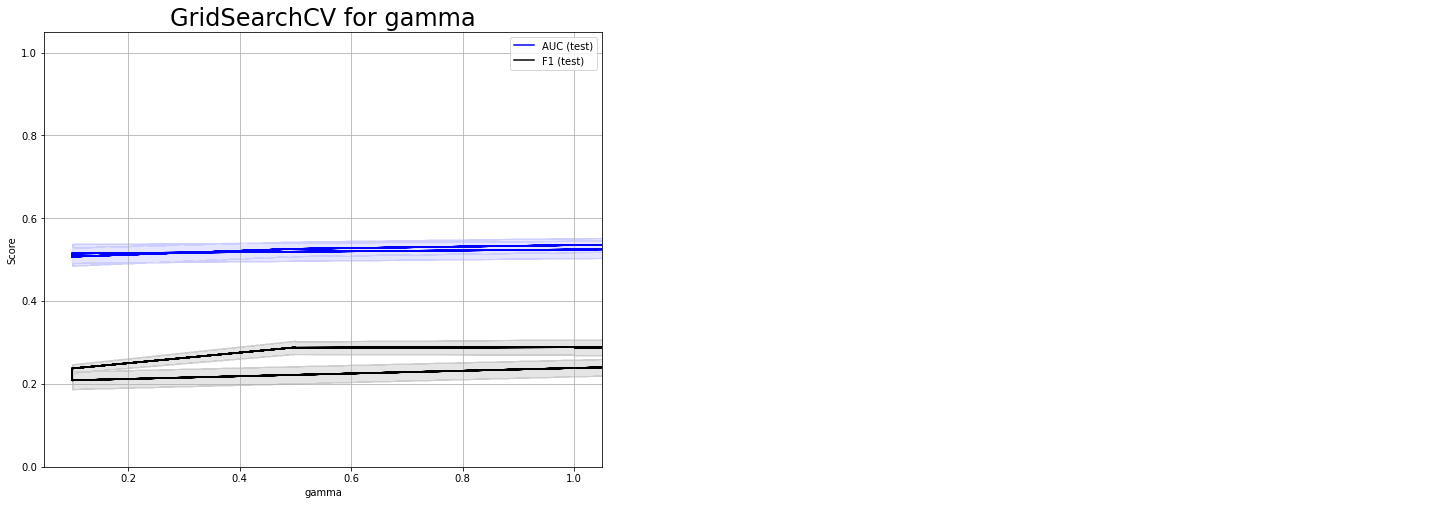

C:\Users\shala\Documents\AI Lab - Technical Interview_Feb2021\AI Lab - Technical Interview\Anomaly Detection\utils.py:58: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


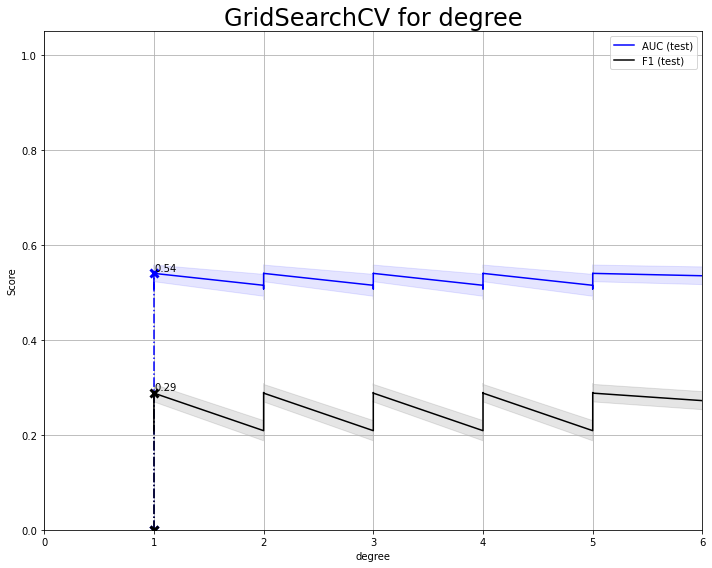

In [32]:
#Optimization process graphs
plot_gridsearch_cv(results, "nu", scoring, 0.1, 0.5, 0, 1.05)
plot_gridsearch_cv(results, "gamma", scoring, 0.05, 2.55, 0, 1.05)
plot_gridsearch_cv(results, "degree", scoring, 0, 6, 0, 1.05)

### H20 AutoML

In [108]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,5 hours 34 mins
H2O_cluster_timezone:,+08:00
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.2
H2O_cluster_version_age:,25 days
H2O_cluster_name:,H2O_from_python_shala_rdq7og
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.425 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [109]:
xH20=list(X.columns)
yH20='label'
h2oTrain=X_train
h2oTest=X_test
h2oTrain[yH20]=y_train
h2oTest[yH20]=y_test

C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\shala\Anaconda3\envs\tf-gpu-2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [110]:
h2oTrain = h2o.H2OFrame(h2oTrain)
h2oTest = h2o.H2OFrame(h2oTest)
h2oTrain[yH20] = h2oTrain[yH20].asfactor()
h2oTest[yH20] = h2oTest[yH20].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [111]:
aml = H2OAutoML(max_models=20, max_runtime_secs=1800, seed=1, stopping_metric='AUCPR')
aml.train(x=xH20, y=yH20, training_frame=h2oTrain)

AutoML progress: |█
00:27:35.616: AutoML: XGBoost is not available; skipping it.

███████████████████████████Failed polling AutoML progress log: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\shala\\AppData\\Local\\Temp\\tmptf8o2u5k.csv'
████████████████████████████| 100%


In [112]:
lb = aml.leaderboard
lb.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20210525_002735,0.985406,0.0947621,0.95958,0.0738926,0.159582,0.0254664
StackedEnsemble_BestOfFamily_AutoML_20210525_002735,0.980836,0.104566,0.951751,0.0698563,0.166012,0.0275599
GBM_grid__1_AutoML_20210525_002735_model_2,0.980785,0.168488,0.952039,0.0794599,0.222627,0.0495626
GBM_4_AutoML_20210525_002735,0.979898,0.143002,0.945783,0.0792953,0.199729,0.0398916
GBM_grid__1_AutoML_20210525_002735_model_4,0.975687,0.173308,0.931691,0.0984138,0.225361,0.0507876
GBM_grid__1_AutoML_20210525_002735_model_6,0.972091,0.164748,0.929291,0.0934767,0.211012,0.0445261
GBM_3_AutoML_20210525_002735,0.970609,0.173061,0.918825,0.110029,0.219796,0.0483104
GBM_1_AutoML_20210525_002735,0.965963,0.180901,0.913848,0.102852,0.2236,0.049997
GBM_2_AutoML_20210525_002735,0.963959,0.193126,0.900153,0.107228,0.232334,0.053979
DRF_1_AutoML_20210525_002735,0.952361,0.249901,0.865836,0.139642,0.266366,0.0709507


In [113]:
y_hat = aml.leader.predict(h2oTest) 
aml.leader.auc()
class_report_H2O = aml.leader.confusion_matrix()

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [114]:
class_report_H2O


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9927157694061189: 


,,0,1,Error,Rate
0,0,4595.0,0.0,0.0,(0.0/4595.0)
1,1,0.0,932.0,0.0,(0.0/932.0)
2,Total,4595.0,932.0,0.0,(0.0/5527.0)


### Neural Network

In [64]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=[recall, f1_factor])

num_epochs = 500

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, min_lr=0.001)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('model_', monitor='loss', restore_best_weights=True)
callbacks = [reduce_lr, model_checkpoint]

X_val, X_test1, y_val, y_test1 = train_test_split(X_test, y_test, test_size=0.5, random_state=7)

history=model.fit(X_train.to_numpy(), y_train.to_numpy(),  epochs=num_epochs, validation_data=(X_val.to_numpy(), y_val.to_numpy()), verbose=2, callbacks=callbacks)


model.summary()

Train on 5527 samples, validate on 1361 samples
Epoch 1/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.6138 - recall: 0.0014 - f1_factor: 7.2254e-04 - val_loss: 0.0711 - val_recall: 0.0000e+00 - val_f1_factor: 0.0000e+00
Epoch 2/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0717 - recall: 0.0000e+00 - f1_factor: 0.0000e+00 - val_loss: 0.0685 - val_recall: 0.0000e+00 - val_f1_factor: 0.0000e+00
Epoch 3/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0710 - recall: 0.0000e+00 - f1_factor: 0.0000e+00 - val_loss: 0.0681 - val_recall: 0.0000e+00 - val_f1_factor: 0.0000e+00
Epoch 4/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0707 - recall: 0.0000e+00 - f1_factor: 0.0000e+00 - val_loss: 0.0676 - val_recall: 0.0000e+00 - val_f1_factor: 0.0000e+00
Epoch 5/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0704 - recall: 0.0000e+00 - f1_fa

INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0615 - recall: 0.2183 - f1_factor: 0.2915 - val_loss: 0.0616 - val_recall: 0.2402 - val_f1_factor: 0.3224
Epoch 42/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0612 - recall: 0.2330 - f1_factor: 0.3064 - val_loss: 0.0611 - val_recall: 0.1081 - val_f1_factor: 0.1649
Epoch 43/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0603 - recall: 0.2329 - f1_factor: 0.3119 - val_loss: 0.0609 - val_recall: 0.1447 - val_f1_factor: 0.2175
Epoch 44/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0606 - recall: 0.2412 - f1_factor: 0.3209 - val_loss: 0.0604 - val_recall: 0.1621 - val_f1_factor: 0.2396
Epoch 45/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0607 - recall: 0.2455 - f1_factor: 0.3246 - val_loss: 0.0602 - val_recall: 0.1792 - val_f1_factor: 0.2585
Epoch 46/1000
INFO:tensorflow:Assets written

5527/5527 - 1s - loss: 0.0538 - recall: 0.4003 - f1_factor: 0.4924 - val_loss: 0.0575 - val_recall: 0.3533 - val_f1_factor: 0.4424
Epoch 84/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0538 - recall: 0.4208 - f1_factor: 0.4987 - val_loss: 0.0589 - val_recall: 0.3463 - val_f1_factor: 0.4281
Epoch 85/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0531 - recall: 0.4232 - f1_factor: 0.5080 - val_loss: 0.0585 - val_recall: 0.2563 - val_f1_factor: 0.3476
Epoch 86/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0529 - recall: 0.4408 - f1_factor: 0.5337 - val_loss: 0.0583 - val_recall: 0.3058 - val_f1_factor: 0.3898
Epoch 87/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0531 - recall: 0.4091 - f1_factor: 0.5000 - val_loss: 0.0572 - val_recall: 0.3104 - val_f1_factor: 0.4130
Epoch 88/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0525 

Epoch 126/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0497 - recall: 0.4622 - f1_factor: 0.5480 - val_loss: 0.0573 - val_recall: 0.3895 - val_f1_factor: 0.4614
Epoch 127/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0490 - recall: 0.4742 - f1_factor: 0.5669 - val_loss: 0.0558 - val_recall: 0.3713 - val_f1_factor: 0.4520
Epoch 128/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0499 - recall: 0.4548 - f1_factor: 0.5497 - val_loss: 0.0553 - val_recall: 0.4095 - val_f1_factor: 0.4859
Epoch 129/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0490 - recall: 0.4610 - f1_factor: 0.5585 - val_loss: 0.0580 - val_recall: 0.3157 - val_f1_factor: 0.4029
Epoch 130/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0500 - recall: 0.4592 - f1_factor: 0.5468 - val_loss: 0.0565 - val_recall: 0.3904 - val_f1_factor: 0.4622
Epoch 131/1000
INFO:tenso

INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0461 - recall: 0.5161 - f1_factor: 0.6076 - val_loss: 0.0544 - val_recall: 0.4238 - val_f1_factor: 0.5053
Epoch 169/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0472 - recall: 0.4963 - f1_factor: 0.5955 - val_loss: 0.0540 - val_recall: 0.3556 - val_f1_factor: 0.4716
Epoch 170/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0470 - recall: 0.4928 - f1_factor: 0.5863 - val_loss: 0.0537 - val_recall: 0.3545 - val_f1_factor: 0.4671
Epoch 171/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0474 - recall: 0.4979 - f1_factor: 0.5905 - val_loss: 0.0562 - val_recall: 0.4254 - val_f1_factor: 0.4910
Epoch 172/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0461 - recall: 0.5191 - f1_factor: 0.6125 - val_loss: 0.0544 - val_recall: 0.4078 - val_f1_factor: 0.4987
Epoch 173/1000
INFO:tensorflow:Assets wr

5527/5527 - 1s - loss: 0.0441 - recall: 0.5553 - f1_factor: 0.6481 - val_loss: 0.0528 - val_recall: 0.3746 - val_f1_factor: 0.4842
Epoch 211/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0454 - recall: 0.5153 - f1_factor: 0.6098 - val_loss: 0.0534 - val_recall: 0.3789 - val_f1_factor: 0.4821
Epoch 212/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0445 - recall: 0.5351 - f1_factor: 0.6299 - val_loss: 0.0524 - val_recall: 0.4061 - val_f1_factor: 0.4942
Epoch 213/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0450 - recall: 0.5393 - f1_factor: 0.6321 - val_loss: 0.0541 - val_recall: 0.4960 - val_f1_factor: 0.5577
Epoch 214/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0443 - recall: 0.5433 - f1_factor: 0.6374 - val_loss: 0.0519 - val_recall: 0.4044 - val_f1_factor: 0.5000
Epoch 215/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.

Epoch 253/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0438 - recall: 0.5415 - f1_factor: 0.6320 - val_loss: 0.0525 - val_recall: 0.3961 - val_f1_factor: 0.5000
Epoch 254/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0419 - recall: 0.5760 - f1_factor: 0.6682 - val_loss: 0.0507 - val_recall: 0.4391 - val_f1_factor: 0.5358
Epoch 255/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0431 - recall: 0.5633 - f1_factor: 0.6544 - val_loss: 0.0518 - val_recall: 0.4010 - val_f1_factor: 0.4952
Epoch 256/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0423 - recall: 0.5670 - f1_factor: 0.6637 - val_loss: 0.0532 - val_recall: 0.3883 - val_f1_factor: 0.4896
Epoch 257/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0431 - recall: 0.5543 - f1_factor: 0.6530 - val_loss: 0.0539 - val_recall: 0.3612 - val_f1_factor: 0.4729
Epoch 258/1000
INFO:tenso

INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0430 - recall: 0.5641 - f1_factor: 0.6476 - val_loss: 0.0514 - val_recall: 0.4891 - val_f1_factor: 0.5596
Epoch 296/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0418 - recall: 0.5603 - f1_factor: 0.6597 - val_loss: 0.0520 - val_recall: 0.4874 - val_f1_factor: 0.5695
Epoch 297/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0420 - recall: 0.5921 - f1_factor: 0.6860 - val_loss: 0.0512 - val_recall: 0.4232 - val_f1_factor: 0.5331
Epoch 298/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0409 - recall: 0.5939 - f1_factor: 0.6833 - val_loss: 0.0525 - val_recall: 0.3895 - val_f1_factor: 0.5009
Epoch 299/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0419 - recall: 0.5530 - f1_factor: 0.6380 - val_loss: 0.0523 - val_recall: 0.3931 - val_f1_factor: 0.4982
Epoch 300/1000
INFO:tensorflow:Assets wr

5527/5527 - 1s - loss: 0.0410 - recall: 0.6038 - f1_factor: 0.6928 - val_loss: 0.0492 - val_recall: 0.4360 - val_f1_factor: 0.5339
Epoch 338/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0406 - recall: 0.5950 - f1_factor: 0.6796 - val_loss: 0.0501 - val_recall: 0.4277 - val_f1_factor: 0.5320
Epoch 339/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0406 - recall: 0.6016 - f1_factor: 0.6990 - val_loss: 0.0501 - val_recall: 0.4199 - val_f1_factor: 0.5390
Epoch 340/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0415 - recall: 0.5718 - f1_factor: 0.6648 - val_loss: 0.0506 - val_recall: 0.4368 - val_f1_factor: 0.5392
Epoch 341/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0401 - recall: 0.5874 - f1_factor: 0.6816 - val_loss: 0.0521 - val_recall: 0.3836 - val_f1_factor: 0.4975
Epoch 342/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.

Epoch 380/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0399 - recall: 0.5943 - f1_factor: 0.6813 - val_loss: 0.0499 - val_recall: 0.4073 - val_f1_factor: 0.5094
Epoch 381/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0401 - recall: 0.5843 - f1_factor: 0.6704 - val_loss: 0.0501 - val_recall: 0.4125 - val_f1_factor: 0.5235
Epoch 382/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0403 - recall: 0.5882 - f1_factor: 0.6747 - val_loss: 0.0486 - val_recall: 0.4902 - val_f1_factor: 0.5770
Epoch 383/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0405 - recall: 0.5884 - f1_factor: 0.6761 - val_loss: 0.0503 - val_recall: 0.4017 - val_f1_factor: 0.5098
Epoch 384/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0400 - recall: 0.5988 - f1_factor: 0.6851 - val_loss: 0.0500 - val_recall: 0.4593 - val_f1_factor: 0.5564
Epoch 385/1000
INFO:tenso

INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0397 - recall: 0.5886 - f1_factor: 0.6781 - val_loss: 0.0521 - val_recall: 0.3654 - val_f1_factor: 0.4880
Epoch 423/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0380 - recall: 0.6239 - f1_factor: 0.7189 - val_loss: 0.0493 - val_recall: 0.5439 - val_f1_factor: 0.6224
Epoch 424/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0394 - recall: 0.5894 - f1_factor: 0.6789 - val_loss: 0.0504 - val_recall: 0.4606 - val_f1_factor: 0.5515
Epoch 425/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0395 - recall: 0.6079 - f1_factor: 0.7000 - val_loss: 0.0489 - val_recall: 0.4837 - val_f1_factor: 0.5775
Epoch 426/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0396 - recall: 0.5998 - f1_factor: 0.6881 - val_loss: 0.0496 - val_recall: 0.5291 - val_f1_factor: 0.6018
Epoch 427/1000
INFO:tensorflow:Assets wr

5527/5527 - 1s - loss: 0.0394 - recall: 0.6099 - f1_factor: 0.6979 - val_loss: 0.0523 - val_recall: 0.3424 - val_f1_factor: 0.4651
Epoch 465/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0381 - recall: 0.6080 - f1_factor: 0.6976 - val_loss: 0.0482 - val_recall: 0.4413 - val_f1_factor: 0.5535
Epoch 466/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0375 - recall: 0.6236 - f1_factor: 0.7209 - val_loss: 0.0501 - val_recall: 0.5216 - val_f1_factor: 0.5797
Epoch 467/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0383 - recall: 0.6213 - f1_factor: 0.7144 - val_loss: 0.0482 - val_recall: 0.4952 - val_f1_factor: 0.5871
Epoch 468/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0386 - recall: 0.6037 - f1_factor: 0.6842 - val_loss: 0.0528 - val_recall: 0.3576 - val_f1_factor: 0.4788
Epoch 469/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.

Epoch 507/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0379 - recall: 0.6306 - f1_factor: 0.7208 - val_loss: 0.0517 - val_recall: 0.3905 - val_f1_factor: 0.5116
Epoch 508/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0367 - recall: 0.6488 - f1_factor: 0.7397 - val_loss: 0.0491 - val_recall: 0.4475 - val_f1_factor: 0.5598
Epoch 509/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0385 - recall: 0.6036 - f1_factor: 0.6937 - val_loss: 0.0494 - val_recall: 0.4358 - val_f1_factor: 0.5450
Epoch 510/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0385 - recall: 0.6011 - f1_factor: 0.6929 - val_loss: 0.0507 - val_recall: 0.4295 - val_f1_factor: 0.5352
Epoch 511/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0384 - recall: 0.6191 - f1_factor: 0.7161 - val_loss: 0.0503 - val_recall: 0.4275 - val_f1_factor: 0.5384
Epoch 512/1000
INFO:tenso

INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0360 - recall: 0.6397 - f1_factor: 0.7334 - val_loss: 0.0483 - val_recall: 0.5068 - val_f1_factor: 0.6012
Epoch 550/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0370 - recall: 0.6257 - f1_factor: 0.7178 - val_loss: 0.0511 - val_recall: 0.3925 - val_f1_factor: 0.5081
Epoch 551/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0368 - recall: 0.6377 - f1_factor: 0.7298 - val_loss: 0.0490 - val_recall: 0.5653 - val_f1_factor: 0.6144
Epoch 552/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0372 - recall: 0.6500 - f1_factor: 0.7424 - val_loss: 0.0494 - val_recall: 0.4617 - val_f1_factor: 0.5633
Epoch 553/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0367 - recall: 0.6257 - f1_factor: 0.7154 - val_loss: 0.0480 - val_recall: 0.4970 - val_f1_factor: 0.5965
Epoch 554/1000
INFO:tensorflow:Assets wr

5527/5527 - 1s - loss: 0.0374 - recall: 0.6275 - f1_factor: 0.7177 - val_loss: 0.0475 - val_recall: 0.5123 - val_f1_factor: 0.6173
Epoch 592/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0375 - recall: 0.6340 - f1_factor: 0.7200 - val_loss: 0.0506 - val_recall: 0.4463 - val_f1_factor: 0.5570
Epoch 593/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0379 - recall: 0.6094 - f1_factor: 0.7012 - val_loss: 0.0493 - val_recall: 0.4352 - val_f1_factor: 0.5423
Epoch 594/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0370 - recall: 0.6245 - f1_factor: 0.7151 - val_loss: 0.0496 - val_recall: 0.4806 - val_f1_factor: 0.5855
Epoch 595/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0371 - recall: 0.6410 - f1_factor: 0.7275 - val_loss: 0.0490 - val_recall: 0.5117 - val_f1_factor: 0.5976
Epoch 596/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.

Epoch 634/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0379 - recall: 0.6158 - f1_factor: 0.7041 - val_loss: 0.0500 - val_recall: 0.3957 - val_f1_factor: 0.5165
Epoch 635/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0351 - recall: 0.6397 - f1_factor: 0.7336 - val_loss: 0.0515 - val_recall: 0.4019 - val_f1_factor: 0.5154
Epoch 636/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0366 - recall: 0.6320 - f1_factor: 0.7277 - val_loss: 0.0483 - val_recall: 0.5259 - val_f1_factor: 0.5994
Epoch 637/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0353 - recall: 0.6454 - f1_factor: 0.7376 - val_loss: 0.0478 - val_recall: 0.5358 - val_f1_factor: 0.6190
Epoch 638/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0361 - recall: 0.6352 - f1_factor: 0.7280 - val_loss: 0.0499 - val_recall: 0.5065 - val_f1_factor: 0.5907
Epoch 639/1000
INFO:tenso

INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0366 - recall: 0.6326 - f1_factor: 0.7287 - val_loss: 0.0466 - val_recall: 0.4970 - val_f1_factor: 0.5999
Epoch 677/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0366 - recall: 0.6404 - f1_factor: 0.7245 - val_loss: 0.0482 - val_recall: 0.4618 - val_f1_factor: 0.5717
Epoch 678/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0360 - recall: 0.6454 - f1_factor: 0.7290 - val_loss: 0.0482 - val_recall: 0.4998 - val_f1_factor: 0.6020
Epoch 679/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0358 - recall: 0.6302 - f1_factor: 0.7259 - val_loss: 0.0465 - val_recall: 0.4791 - val_f1_factor: 0.5914
Epoch 680/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0355 - recall: 0.6468 - f1_factor: 0.7414 - val_loss: 0.0473 - val_recall: 0.4622 - val_f1_factor: 0.5710
Epoch 681/1000
INFO:tensorflow:Assets wr

5527/5527 - 1s - loss: 0.0356 - recall: 0.6489 - f1_factor: 0.7402 - val_loss: 0.0473 - val_recall: 0.4787 - val_f1_factor: 0.5838
Epoch 719/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0343 - recall: 0.6667 - f1_factor: 0.7524 - val_loss: 0.0444 - val_recall: 0.5391 - val_f1_factor: 0.6334
Epoch 720/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0360 - recall: 0.6482 - f1_factor: 0.7304 - val_loss: 0.0483 - val_recall: 0.4657 - val_f1_factor: 0.5740
Epoch 721/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0363 - recall: 0.6345 - f1_factor: 0.7342 - val_loss: 0.0486 - val_recall: 0.4440 - val_f1_factor: 0.5528
Epoch 722/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0355 - recall: 0.6608 - f1_factor: 0.7446 - val_loss: 0.0480 - val_recall: 0.5298 - val_f1_factor: 0.6043
Epoch 723/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.

Epoch 761/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0361 - recall: 0.6404 - f1_factor: 0.7294 - val_loss: 0.0462 - val_recall: 0.5146 - val_f1_factor: 0.6108
Epoch 762/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0335 - recall: 0.6831 - f1_factor: 0.7765 - val_loss: 0.0455 - val_recall: 0.5226 - val_f1_factor: 0.6097
Epoch 763/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0345 - recall: 0.6578 - f1_factor: 0.7520 - val_loss: 0.0465 - val_recall: 0.5129 - val_f1_factor: 0.5942
Epoch 764/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0367 - recall: 0.6514 - f1_factor: 0.7327 - val_loss: 0.0473 - val_recall: 0.5275 - val_f1_factor: 0.5985
Epoch 765/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0354 - recall: 0.6369 - f1_factor: 0.7314 - val_loss: 0.0465 - val_recall: 0.5019 - val_f1_factor: 0.5984
Epoch 766/1000
INFO:tenso

INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0349 - recall: 0.6479 - f1_factor: 0.7425 - val_loss: 0.0480 - val_recall: 0.5076 - val_f1_factor: 0.5935
Epoch 804/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0361 - recall: 0.6536 - f1_factor: 0.7403 - val_loss: 0.0502 - val_recall: 0.4356 - val_f1_factor: 0.5490
Epoch 805/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0350 - recall: 0.6559 - f1_factor: 0.7477 - val_loss: 0.0467 - val_recall: 0.5334 - val_f1_factor: 0.6212
Epoch 806/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0349 - recall: 0.6761 - f1_factor: 0.7567 - val_loss: 0.0464 - val_recall: 0.4964 - val_f1_factor: 0.6092
Epoch 807/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0338 - recall: 0.6806 - f1_factor: 0.7658 - val_loss: 0.0468 - val_recall: 0.5202 - val_f1_factor: 0.6162
Epoch 808/1000
INFO:tensorflow:Assets wr

5527/5527 - 1s - loss: 0.0349 - recall: 0.6559 - f1_factor: 0.7455 - val_loss: 0.0484 - val_recall: 0.5015 - val_f1_factor: 0.5944
Epoch 846/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0342 - recall: 0.6694 - f1_factor: 0.7511 - val_loss: 0.0472 - val_recall: 0.5220 - val_f1_factor: 0.6160
Epoch 847/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0348 - recall: 0.6623 - f1_factor: 0.7461 - val_loss: 0.0474 - val_recall: 0.5328 - val_f1_factor: 0.6139
Epoch 848/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0351 - recall: 0.6624 - f1_factor: 0.7417 - val_loss: 0.0466 - val_recall: 0.5210 - val_f1_factor: 0.6249
Epoch 849/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0347 - recall: 0.6594 - f1_factor: 0.7535 - val_loss: 0.0495 - val_recall: 0.4506 - val_f1_factor: 0.5712
Epoch 850/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.

Epoch 888/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0358 - recall: 0.6442 - f1_factor: 0.7282 - val_loss: 0.0463 - val_recall: 0.5265 - val_f1_factor: 0.6045
Epoch 889/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0343 - recall: 0.6648 - f1_factor: 0.7480 - val_loss: 0.0459 - val_recall: 0.5312 - val_f1_factor: 0.6256
Epoch 890/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0344 - recall: 0.6650 - f1_factor: 0.7591 - val_loss: 0.0479 - val_recall: 0.5129 - val_f1_factor: 0.5986
Epoch 891/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0337 - recall: 0.6854 - f1_factor: 0.7729 - val_loss: 0.0465 - val_recall: 0.5328 - val_f1_factor: 0.6279
Epoch 892/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0328 - recall: 0.6811 - f1_factor: 0.7673 - val_loss: 0.0453 - val_recall: 0.5481 - val_f1_factor: 0.6491
Epoch 893/1000
INFO:tenso

INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0333 - recall: 0.6914 - f1_factor: 0.7767 - val_loss: 0.0507 - val_recall: 0.4263 - val_f1_factor: 0.5464
Epoch 931/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0333 - recall: 0.6706 - f1_factor: 0.7645 - val_loss: 0.0481 - val_recall: 0.4756 - val_f1_factor: 0.5837
Epoch 932/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0332 - recall: 0.6921 - f1_factor: 0.7742 - val_loss: 0.0481 - val_recall: 0.4769 - val_f1_factor: 0.5823
Epoch 933/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0335 - recall: 0.6778 - f1_factor: 0.7698 - val_loss: 0.0488 - val_recall: 0.4821 - val_f1_factor: 0.5783
Epoch 934/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0335 - recall: 0.6748 - f1_factor: 0.7551 - val_loss: 0.0478 - val_recall: 0.4546 - val_f1_factor: 0.5794
Epoch 935/1000
INFO:tensorflow:Assets wr

5527/5527 - 1s - loss: 0.0334 - recall: 0.6794 - f1_factor: 0.7645 - val_loss: 0.0489 - val_recall: 0.5548 - val_f1_factor: 0.6214
Epoch 973/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0348 - recall: 0.6529 - f1_factor: 0.7380 - val_loss: 0.0465 - val_recall: 0.5280 - val_f1_factor: 0.6213
Epoch 974/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0335 - recall: 0.6835 - f1_factor: 0.7779 - val_loss: 0.0462 - val_recall: 0.5692 - val_f1_factor: 0.6473
Epoch 975/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0331 - recall: 0.6803 - f1_factor: 0.7692 - val_loss: 0.0469 - val_recall: 0.4947 - val_f1_factor: 0.5927
Epoch 976/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.0348 - recall: 0.6679 - f1_factor: 0.7407 - val_loss: 0.0478 - val_recall: 0.4975 - val_f1_factor: 0.6015
Epoch 977/1000
INFO:tensorflow:Assets written to: model_\assets
5527/5527 - 1s - loss: 0.

In [65]:
y_pred=np.around(model.predict(X_test1).astype(float))

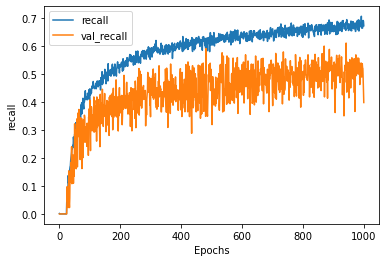

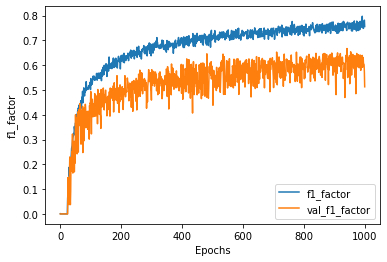

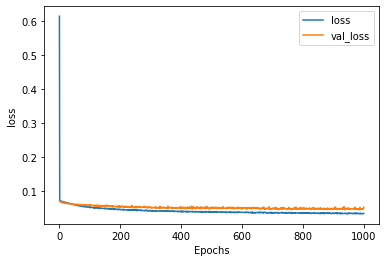

In [66]:
plot_graphs(history, "recall")
plot_graphs(history, "f1_factor")
plot_graphs(history, "loss")

In [67]:
class_report_NN=report_USL(y_pred, y_test1.to_numpy())

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1126
           1       0.91      0.44      0.59       236

    accuracy                           0.90      1362
   macro avg       0.90      0.71      0.77      1362
weighted avg       0.90      0.90      0.88      1362

CONFUSION MATRIX
[[1116   10]
 [ 133  103]]


In [68]:
d = {'model': ['Isolation forest', 'Local Outlier Factor', 'One-Class SVM', 'NN Classifier'], 
     'Recall(1)': [recall_cm(class_report_IF), recall_cm(class_report_LOF), recall_cm(class_report_OSVM), recall_cm(class_report_NN)], 
     'F1 score(1)': [f1_factor_cm(class_report_IF), f1_factor_cm(class_report_LOF), f1_factor_cm(class_report_OSVM), f1_factor_cm(class_report_NN)],
     'Precision(0)': [precision_cm0(class_report_IF), precision_cm0(class_report_LOF), precision_cm0(class_report_OSVM), precision_cm0(class_report_NN)]
    }

In [69]:
df_comp = pd.DataFrame(data=d)

In [70]:
print(df_comp)
print('5     H2O AutoML          1.0          1.0           1.0 ')

                  model  Recall(1)  F1 score(1)  Precision(0)
0      Isolation forest   0.874725     0.273352      0.785714
1  Local Outlier Factor   0.562637     0.262564      0.837948
2         One-Class SVM   0.980220     0.284167      0.769231
3         NN Classifier   0.436441     0.590258      0.893515
5     H2O AutoML          1.0          1.0           1.0 
